# Honey Purity Prediction🍯

### *Loading Dataset*

In [4]:
#Import necessary libraries
import pandas as pd
import numpy as np

In [5]:
#Load dataset
df = pd.read_csv('../data/Cleaned_data.csv')

In [6]:
df

,Color Score,Density,Water Content,pH,Electrical Conductivity,Fructose Level,Glucose Level,Pollen Analysis,Viscosity,Purity,Price
0,2.81,1.75,23.04,6.29,0.76,39.02,33.63,Blueberry,4844.50,0.68,645.24
1,9.47,1.82,17.50,7.20,0.71,38.15,34.41,Alfalfa,6689.02,0.89,385.85
2,4.61,1.84,23.72,7.31,0.80,27.47,34.36,Chestnut,6883.60,0.66,639.64
3,1.77,1.40,16.61,4.01,0.78,31.52,28.15,Blueberry,7167.56,1.00,946.46
4,6.11,1.25,19.63,4.82,0.90,29.65,42.52,Alfalfa,5125.44,1.00,432.62
...,...,...,...,...,...,...,...,...,...,...,...
247898,1.98,1.29,17.90,4.82,0.89,36.10,34.69,Rosemary,8261.63,1.00,754.98
247899,6.18,1.67,19.54,4.91,0.85,31.15,20.82,Acacia,6939.39,1.00,543.41
247900,7.78,1.49,15.78,5.69,0.73,44.60,44.07,Chestnut,4139.79,0.64,615.46
247901,5.78,1.74,14.96,6.81,0.83,47.19,37.79,Avocado,4417.74,0.97,949.32


### *Machine Learning Models*

In [7]:
#Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

In [8]:
#Preprocess the data
def preprocess_data(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(['Electrical Conductivity', 'Glucose Level', 'Fructose Level'], axis=1)
    
    #One hot Encoding
    one_hot_encoded_df = pd.get_dummies(df_copy['Pollen Analysis'], prefix='Pollen_Analysis')
    df_copy = pd.concat([df_copy, one_hot_encoded_df], axis=1)
    df_copy.drop('Pollen Analysis', axis=1, inplace=True)

    #Normalization
    scaler = MinMaxScaler()
    df_copy[df_copy.columns] = scaler.fit_transform(df_copy[df_copy.columns])
    return df_copy

In [9]:
#Cross-validation and evaluation
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = [math.sqrt(-score) for score in scores]
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    #Training on the training set
    model.fit(X_train, y_train)
    
    #Predicting on the test set
    y_pred = model.predict(X_test)
    
    #Computing test set metrics
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, np.mean(rmse_scores), np.mean(r2_scores), np.mean(mae_scores), test_rmse, test_r2, test_mae]

In [37]:
df_preprocessed = preprocess_data(df)
X = df_preprocessed.drop(['Purity'], axis=1)
y = df_preprocessed['Purity']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=1.0)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

results = []

for name, model in models:
    result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
    results.append(result)

print('')
print('-'*30)
print('Evaluation complete!')

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating XGBoost...

------------------------------
Evaluation complete!


In [38]:
results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 
                                            'Test RMSE', 'Test R-squared', 'Test MAE'])
results_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE
0,Linear Regression,0.117482,0.892085,0.082122,0.118045,0.890575,0.082368
1,Ridge Regression,0.117481,0.892088,0.082072,0.118036,0.890592,0.082317
2,Lasso Regression,0.357630,-0.000012,0.312263,0.356874,-0.000112,0.310879
3,Random Forest,0.026330,0.994578,0.005290,0.023684,0.995595,0.004305
4,Gradient Boosting,0.072075,0.959376,0.049190,0.072160,0.959110,0.048904
5,XGBoost,0.022744,0.995946,0.008782,0.019902,0.996890,0.008038


In [11]:
#XGBoost model - Best performing model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

In [33]:
xgb_results = pd.DataFrame({'Actual Purity': y_test, 'Predicted Purity': y_pred_xgb})
xgb_results['Actual Purity'] = xgb_results['Actual Purity'].round(2)
xgb_results['Predicted Purity'] = xgb_results['Predicted Purity'].round(2)
xgb_results.sample(n=5)

,Actual Purity,Predicted Purity
203499,0.13,0.13
185918,0.59,0.60
12254,0.92,0.93
16624,0.49,0.48
14801,0.13,0.12


In [ ]:
#Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

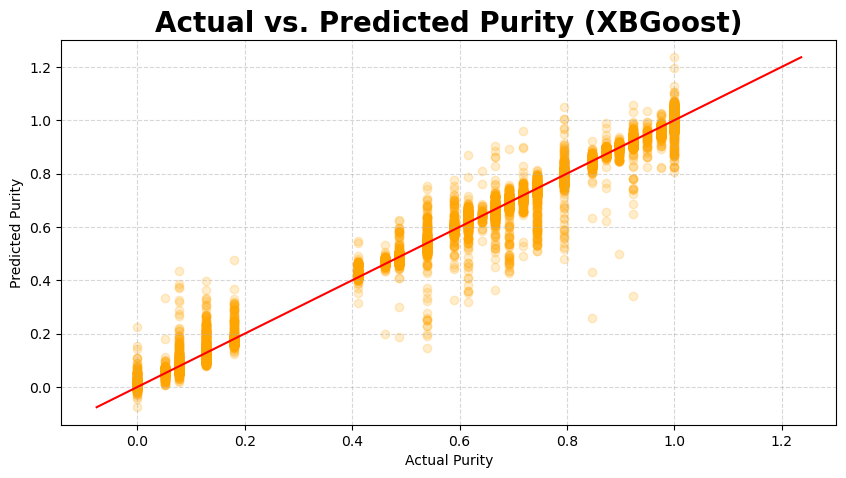

In [38]:
#Scatterplot - Actual vs. Predicted purity
plt.figure(figsize=(10,5))

plt.scatter(y_test, y_pred_xgb, alpha=0.2, color='orange')
plt.plot([min(y_pred_xgb), max(y_pred_xgb)], [min(y_pred_xgb), max(y_pred_xgb)], color='red')

plt.title('Actual vs. Predicted Purity (XBGoost)', size=20, weight='bold', y=0.999)
plt.xlabel('Actual Purity')
plt.ylabel('Predicted Purity')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.show()

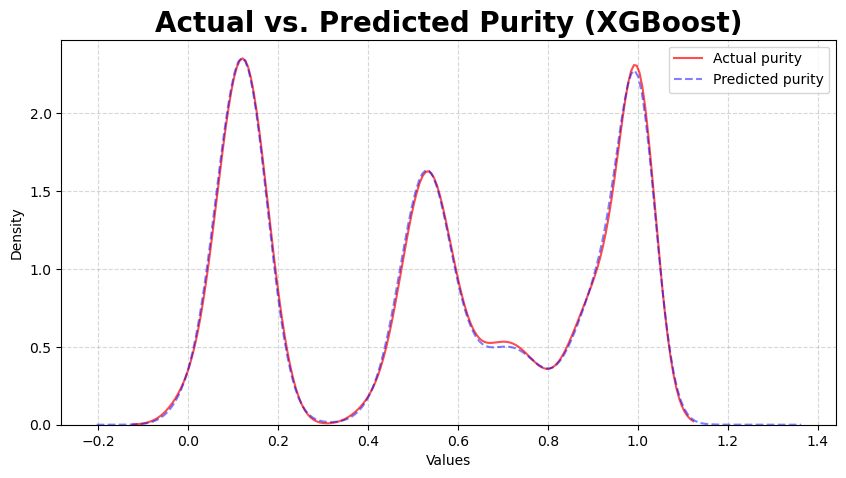

In [37]:
#KDEplot - Actual vs. Predicted purity
plt.figure(figsize=(10, 5))

sns.kdeplot(xgb_results['Actual Purity'], color='r', label='Actual purity', alpha=0.7)
sns.kdeplot(xgb_results['Predicted Purity'], color='b', label='Predicted purity', alpha=0.5, linestyle='--')

plt.title('Actual vs. Predicted Purity (XGBoost)', size=20, weight='bold', y=0.999)
plt.xlabel('Values')
plt.ylabel('Density')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.legend()
plt.show()